# IMPORT LIBRARIES/DATASETS

In [1]:
# import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.applications.mobilenet import MobileNet
from keras.layers import *
from keras.models import Model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint


2023-02-25 08:40:07.386363: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from utils.data_generators import train_generator, validation_generator, test_generator
from utils.globals import categorical_labels

labels = categorical_labels


Found 915 images belonging to 3 classes.
Found 114 images belonging to 3 classes.
Found 115 images belonging to 3 classes.


In [3]:
# load the inception resnetv2 model
basemodel = MobileNet(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=(256, 256, 3))
)

# Freeze the basemodel weights , so these weights won't change during training
basemodel.trainable = False


2023-02-25 08:40:13.256259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


17225924/17225924 [==============================] - 5s 0us/step


In [4]:
# print the model summary
basemodel.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 128, 128, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 128, 128, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 128, 128, 32)     128       
 ation)                                         

In [5]:
# Add classification head to the model

headmodel = basemodel.output
headmodel = GlobalAveragePooling2D(name = 'global_average_pool')(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu", name = 'dense_1')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu", name = 'dense_2')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(3, activation = 'softmax', name = 'dense_3')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [6]:
# print the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 128, 128, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 128, 128, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 128, 128, 32)     128       
 ation)                                                      

In [7]:
# compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(lr=.01, momentum=.9),
    metrics=["accuracy"]
)


/Users/abdulrahmanwaleed/.pyenv/versions/3.7.16/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights/MobileNet.hdf5", verbose=1, save_best_only=True)

In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // 32,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // 32,
    callbacks=[checkpointer, earlystopping]
)


Epoch 1/5
28/28 [==============================] - ETA: 0s - loss: 0.6836 - accuracy: 0.7078
Epoch 1: val_loss improved from inf to 0.32634, saving model to weights/MobileNet.hdf5
28/28 [==============================] - 46s 2s/step - loss: 0.6836 - accuracy: 0.7078 - val_loss: 0.3263 - val_accuracy: 0.8542
Epoch 2/5
28/28 [==============================] - ETA: 0s - loss: 0.3774 - accuracy: 0.8562
Epoch 2: val_loss did not improve from 0.32634
28/28 [==============================] - 41s 1s/step - loss: 0.3774 - accuracy: 0.8562 - val_loss: 0.4663 - val_accuracy: 0.8438
Epoch 3/5
28/28 [==============================] - ETA: 0s - loss: 0.2979 - accuracy: 0.8845
Epoch 3: val_loss did not improve from 0.32634
28/28 [==============================] - 41s 1s/step - loss: 0.2979 - accuracy: 0.8845 - val_loss: 0.3648 - val_accuracy: 0.8542
Epoch 4/5
28/28 [==============================] - ETA: 0s - loss: 0.2587 - accuracy: 0.9037
Epoch 4: val_loss improved from 0.32634 to 0.31764, saving m

In [10]:
model.save('models/MobileNet.h5')

In [11]:
# Evaluate the performance of the model
evaluate = model.evaluate(
    test_generator,
    steps=test_generator.n // 32,
    verbose=1
)

print('Accuracy Test : {}'.format(evaluate[1]))


3/3 [==============================] - 3s 872ms/step - loss: 0.3270 - accuracy: 0.9167
Accuracy Test : 0.9166666865348816


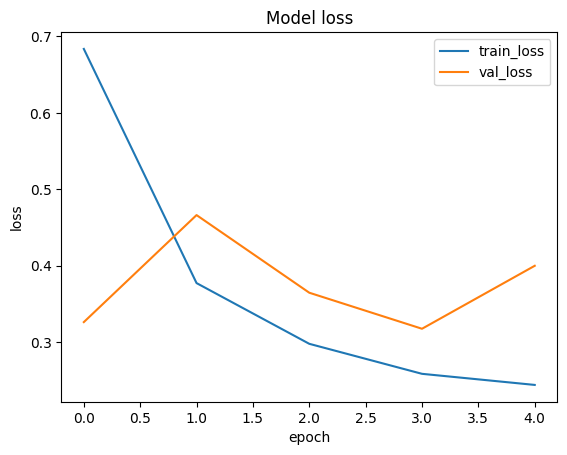

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.show()


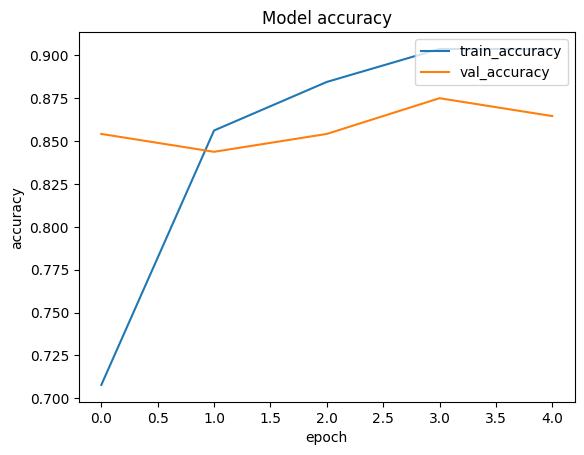

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper right')
plt.show()


In [14]:
# loading images and their predictions
from utils.heplers import test_model
from utils.globals import input_path
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction, original, image = test_model(model, labels, input_path)

1/1 [==============================] - 0s 63ms/step


In [15]:
# Getting the test accuracy
score = accuracy_score(original, prediction)
print("Test Accuracy : {}".format(score))


Test Accuracy : 0.9217391304347826


In [16]:
# classification report
print(classification_report(np.asarray(original), np.asarray(prediction)))


                precision    recall  f1-score   support

Necrotic-Tumor       0.82      0.92      0.87        25
     Non-Tumor       0.96      0.90      0.93        51
        Viable       0.95      0.95      0.95        39

      accuracy                           0.92       115
     macro avg       0.91      0.92      0.92       115
  weighted avg       0.93      0.92      0.92       115



Text(0.5, 1.0, 'Confusion_matrix')

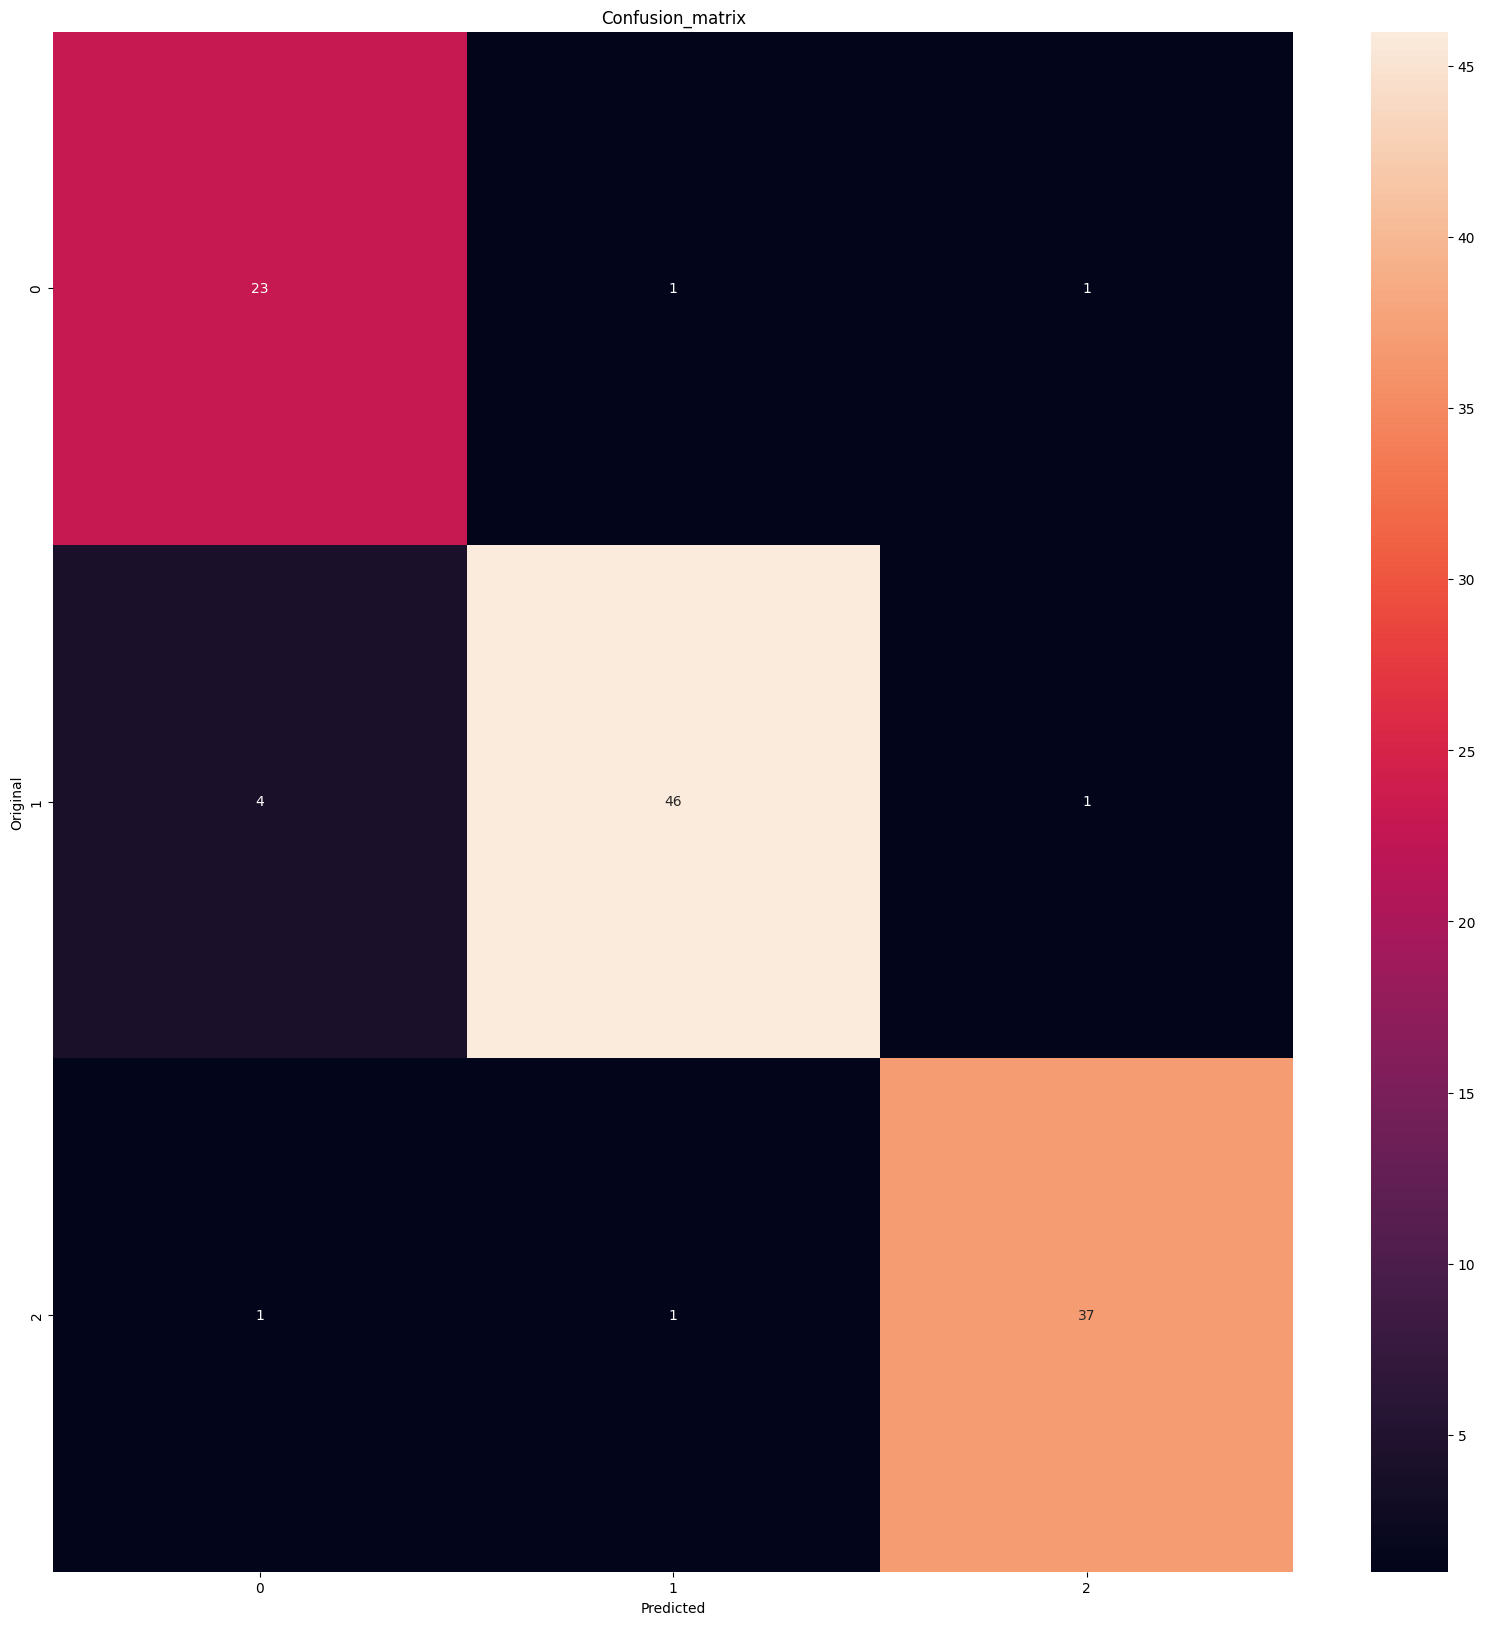

In [17]:
# plot confusion matrix
plt.figure(figsize=(20, 20))
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')


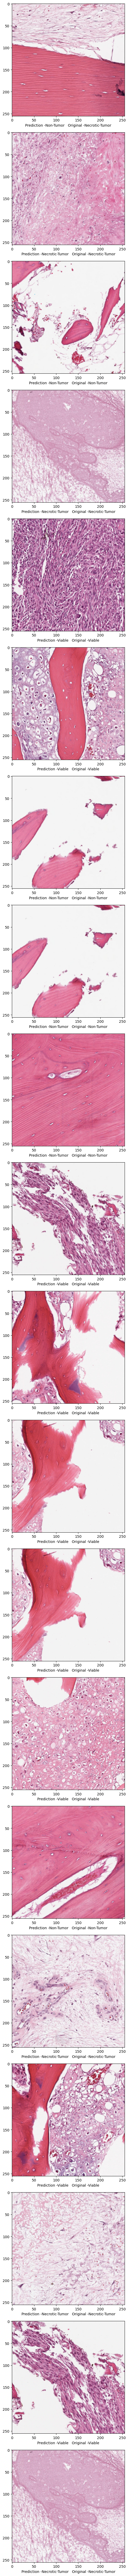

In [18]:
# visualizing the results
import random
fig = plt.figure(figsize=(100, 100))
for i in range(20):
    j = random.randint(0, len(image))
    fig.add_subplot(20, 1, i+1)
    plt.xlabel("Prediction -" + prediction[j] + "   Original -" + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()
